# Домашнее задание 2. StarGAN

## Этап 1. Установка зависимостей, инициализация и загрузка данных

В этом разделе мы работаем с датасетом CelebA, содержащим изображения лиц с набором атрибутов. Целью задания является генерация новых изображений лиц с заданными характеристиками.

In [22]:
%pip install lpips -q

# import sys
# sys.path.append('/Users/konstantin/Desktop/HSE/ДЗ/Генеративки/homeworks/HW-2/data/celeba')  # Добавляем путь к CelebADataset

import torch
from lpips import LPIPS
from torchvision import transforms
from munch import Munch
from tqdm.auto import trange
import matplotlib.pyplot as plt
import numpy as np
from celeba import CelebADataset

device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device(device)

Note: you may need to restart the kernel to use updated packages.


In [23]:
args = Munch()
args.img_size = 64  # Размер изображений после преобразования

# Создание последовательности преобразований для подготовки изображений
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Загрузка датасета CelebA с применением указанных преобразований
dataset = CelebADataset(
    root_dir='data',
    transform=transform)

# Число потоков для загрузки данных
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# args.batch_size = ...   # Задайте размер батча
args.batch_size = 8

# Создание DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=args.batch_size,
    # num_workers=num_workers,
    # pin_memory=pin_memory,
    shuffle=True
)

In [24]:
# args.num_domains = ...  # Задайте число доменов
args.num_domains = len(dataset.header) 

### Визуализация датасета

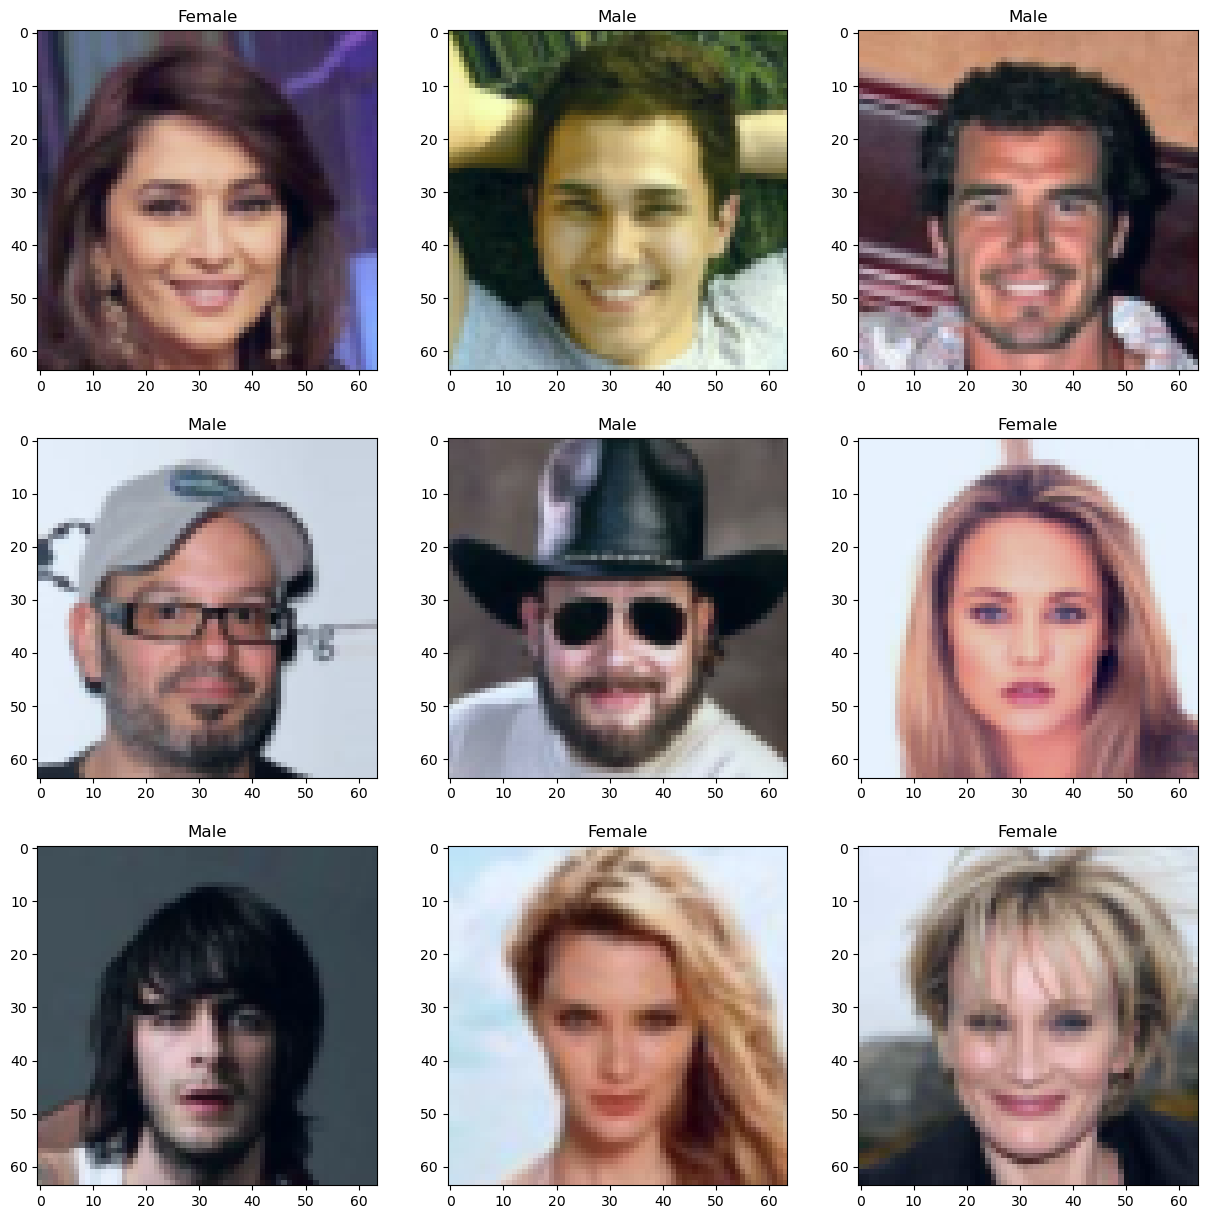

In [25]:
# Визуализация случайно выбранных изображений из датасета
_, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), 9)):

    img, target = dataset[img_idx]
    img = (img - img.min()) / (img.max() - img.min())
    axes[i // 3][i % 3].imshow(img.detach().cpu().numpy().transpose(1, 2, 0))
    # print(target)
    axes[i // 3][i % 3].set_title('Male' if target['attributes'][20] == 1 else 'Female')

## Этап 2. Инициализация и обучение модели

В этом этапе необходимо реализовать и обучить модель StarGAN для генерации лиц с заданными атрибутами.

Вы можете выбрать одну из следующих моделей:
- [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**)
- [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

### Инициализация

Ниже приведён шаблон для определения основных компонентов модели. Реализуйте их по своему усмотрению.

In [ ]:
import math

from munch import Munch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, actv=nn.LeakyReLU(0.2),
                 normalize=False, downsample=False):
        super().__init__()
        self.actv = actv
        self.normalize = normalize
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out)

    def _build_weights(self, dim_in, dim_out):
        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        x = self.conv1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self._shortcut(x) + self._residual(x)
        return x / math.sqrt(2) 


class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta


class AdainResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=64, w_hpf=0,
                 actv=nn.LeakyReLU(0.2), upsample=False):
        super().__init__()
        self.w_hpf = w_hpf
        self.actv = actv
        self.upsample = upsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out, style_dim)

    def _build_weights(self, dim_in, dim_out, style_dim=64):
        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.norm2 = AdaIN(style_dim, dim_out)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.learned_sc:
            x = self.conv1x1(x)
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.actv(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        x = self.norm2(x, s)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x, s):
        out = self._residual(x, s)
        if self.w_hpf == 0:
            out = (out + self._shortcut(x)) / math.sqrt(2)
        return out


class HighPass(nn.Module):
    def __init__(self, w_hpf, device):
        super(HighPass, self).__init__()
        self.register_buffer('filter',
                             torch.tensor([[-1, -1, -1],
                                           [-1, 8., -1],
                                           [-1, -1, -1]]) / w_hpf)

    def forward(self, x):
        filter = self.filter.unsqueeze(0).unsqueeze(1).repeat(x.size(1), 1, 1, 1)
        return F.conv2d(x, filter, padding=1, groups=x.size(1))


class Generator(nn.Module):
    def __init__(self, img_size=256, style_dim=64, max_conv_dim=512, w_hpf=1):
        super().__init__()
        dim_in = 2**14 // img_size
        self.img_size = img_size
        self.from_rgb = nn.Conv2d(3, dim_in, 3, 1, 1)
        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()
        self.to_rgb = nn.Sequential(
            nn.InstanceNorm2d(dim_in, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, 3, 1, 1, 0))

        repeat_num = int(np.log2(img_size)) - 4
        if w_hpf > 0:
            repeat_num += 1
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            self.encode.append(
                ResBlk(dim_in, dim_out, normalize=True, downsample=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_in, style_dim,
                               w_hpf=w_hpf, upsample=True)) 
            dim_in = dim_out

        for _ in range(2):
            self.encode.append(
                ResBlk(dim_out, dim_out, normalize=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_out, style_dim, w_hpf=w_hpf))

        if w_hpf > 0:
            device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
            self.hpf = HighPass(w_hpf, device)

    def forward(self, x, s, masks=None):
        x = self.from_rgb(x)
        cache = {}
        for block in self.encode:
            if (masks is not None) and (x.size(2) in [32, 64, 128]):
                cache[x.size(2)] = x
            x = block(x)
        for block in self.decode:
            x = block(x, s)
            if (masks is not None) and (x.size(2) in [32, 64, 128]):
                mask = masks[0] if x.size(2) in [32] else masks[1]
                mask = F.interpolate(mask, size=x.size(2), mode='bilinear')
                x = x + self.hpf(mask * cache[x.size(2)])
        return self.to_rgb(x)


class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=64, num_domains=2):
        super().__init__()
        layers = []
        layers += [nn.Linear(latent_dim, 512)]
        layers += [nn.ReLU()]
        for _ in range(3):
            layers += [nn.Linear(512, 512)]
            layers += [nn.ReLU()]
        self.shared = nn.Sequential(*layers)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Sequential(nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, style_dim))]

    def forward(self, z, y):
        h = self.shared(z)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1) 
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y] 
        return s


class StyleEncoder(nn.Module):
    def __init__(self, img_size=256, style_dim=64, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        self.shared = nn.Sequential(*blocks)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Linear(dim_out, style_dim)]

    def forward(self, x, y):
        h = self.shared(x)
        h = h.view(h.size(0), -1)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1) 
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y] 
        return s


class Discriminator(nn.Module):
    def __init__(self, img_size=256, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, num_domains, 1, 1, 0)]
        self.main = nn.Sequential(*blocks)

    def forward(self, x, y):
        out = self.main(x)
        out = out.view(out.size(0), -1) 
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        out = out[idx, y] 
        return out


def build_model(args):
    generator = Generator(args.img_size, args.style_dim, w_hpf=args.w_hpf).to(device).float()
    mapping_network = MappingNetwork(args.latent_dim, args.style_dim, args.num_domains).to(device).float()
    style_encoder = StyleEncoder(args.img_size, args.style_dim, args.num_domains).to(device).float()
    discriminator = Discriminator(args.img_size, args.num_domains).to(device).float()

    nets = Munch(generator=generator,
                 mapping_network=mapping_network,
                 style_encoder=style_encoder,
                 discriminator=discriminator)

    return nets

### Обучение

In [31]:
def compute_d_loss(nets, args, x_real, y_org, y_trg, x_ref=None, z=None):
    assert (z is None) != (x_ref is None)
    
    if x_ref is not None:
        s_trg = nets.style_encoder(x_ref, y_trg)
    else:
        s_trg = nets.mapping_network(z, y_trg)
    
    x_fake = nets.generator(x_real, s_trg)
    out_real = nets.discriminator(x_real, y_org)
    out_fake = nets.discriminator(x_fake.detach(), y_trg)
    
    loss_real = F.softplus(-out_real).mean()
    loss_fake = F.softplus(out_fake).mean()
    loss_adv = loss_real + loss_fake

    x_real.requires_grad = True
    out_real = nets.discriminator(x_real, y_org)
    grad_real, = torch.autograd.grad(
        outputs=out_real.sum(), inputs=x_real, create_graph=True
    )
    grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1)**2).mean()
    grad_penalty = args.gamma / 2 * grad_penalty
    
    total_loss = loss_adv + grad_penalty
    
    return total_loss, Munch(adv=loss_adv.item(), gp=grad_penalty.item())


def compute_g_loss(nets, args, x_real, y_org, y_trg, x_ref=None, z=None):
    assert (z is None) != (x_ref is None)
    
    if x_ref is not None:
        s_trg = [nets.style_encoder(x_ref, y_trg) for x_ref in x_ref]
    else:
        s_trg = [nets.mapping_network(z, y_trg) for z in z]
    
    x_fake = nets.generator(x_real, s_trg[0])
    out_fake = nets.discriminator(x_fake, y_trg)
    loss_adv = F.softplus(-out_fake).mean()

    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = F.l1_loss(s_pred, s_trg[0].detach())

    if x_ref is not None and len(x_ref) > 1:
        s_org = nets.style_encoder(x_ref[1], y_org)
        x_rec = nets.generator(x_fake, s_org)
        loss_cyc = F.l1_loss(x_rec, x_real)
    else:
        loss_cyc = torch.tensor(0.0).to(x_real.device)

    if len(s_trg) > 1:
        x_fake2 = nets.generator(x_real, s_trg[1])
        loss_ds = F.l1_loss(x_fake, x_fake2)
    else:
        loss_ds = torch.tensor(0.0).to(x_real.device)
    
    total_loss = (loss_adv + args.lambda_style * loss_sty + args.lambda_cycle * loss_cyc - loss_ds)
    
    return total_loss, Munch(
        adv=loss_adv.item(),
        style=loss_sty.item(),
        cycle=loss_cyc.item(),
        ds=loss_ds.item()
    )

In [ ]:
args = Munch(
    img_size=64,
    style_dim=64,
    latent_dim=64,
    num_domains=5,      
    w_hpf=0,
    gamma=10,           
    lambda_style=1.0,
    lambda_cycle=1.0,
    lr=1e-4,
    batch_size=8,       
    num_iters=3000
)

nets = build_model(args)
optimizers = Munch(
    generator=torch.optim.Adam(nets.generator.parameters(), lr=args.lr, betas=(0.5, 0.999)),
    discriminator=torch.optim.Adam(nets.discriminator.parameters(), lr=args.lr, betas=(0.5, 0.999)),
    mapping_network=torch.optim.Adam(nets.mapping_network.parameters(), lr=args.lr, betas=(0.5, 0.999)),
    style_encoder=torch.optim.Adam(nets.style_encoder.parameters(), lr=args.lr, betas=(0.5, 0.999))
)

dataloader_iter = iter(dataloader)
    
for iteration in trange(3000):
    try:
        x_real, other = next(dataloader_iter)
    except StopIteration:
        dataloader_iter = iter(dataloader)
        x_real, other = next(dataloader_iter)
    actual_batch_size = x_real.size(0)   
    x_real = x_real.to(device, dtype=torch.float32)
    y_original = torch.tensor([other['attributes'][i].argmax() for i in range(actual_batch_size)], device=device, dtype=torch.long)
    x_ref, _ = next(iter(dataloader))
    x_ref = x_ref[:actual_batch_size].to(device, dtype=torch.float32)
    y_trg = torch.randint(0, args.num_domains, (actual_batch_size,), device=device, dtype=torch.long)

    optimizers.discriminator.zero_grad(set_to_none=True)
    d_loss_ref, _ = compute_d_loss(nets, args, x_real, y_original, y_trg, x_ref=x_ref)
    d_loss_ref.backward()
    optimizers.discriminator.step()
    
    for opt in [optimizers.generator, optimizers.style_encoder, optimizers.mapping_network]:
        opt.zero_grad(set_to_none=True)
    
    g_loss_ref, _ = compute_g_loss(nets, args, x_real, y_original, y_trg, x_ref=[x_ref])
    g_loss_ref.backward()
    
    torch.nn.utils.clip_grad_norm_(nets.generator.parameters(), max_norm=1.0)
    
    for opt in [optimizers.generator, optimizers.style_encoder, optimizers.mapping_network]:
        opt.step()


  0%|          | 0/3000 [00:00<?, ?it/s]

### Оценка модели

Для оценки качества сгенерированных изображений используется метрика LPIPS.

In [35]:
lpips = LPIPS().to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/opt/anaconda3/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu')

In [141]:
def f(tensor):
    return tensor * torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1) + torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)

test_iters = 100  # Количество итераций для тестирования модели
values = []

for i in trange(test_iters):
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    
    batch_size = x_real.shape[0]
    
    # Случайное задание целевого и исходного доменов для каждого изображения
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Исходный домен
    
    # Перенос данных на выбранное устройство и приведение типов
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    # Генерация изображения с использованием вашей модели
    # raise NotImplementedError("Реализуйте генерацию изображения x_fake с использованием вашей модели")
    
    # Вычисление LPIPS между сгенерированным и реальным изображением
    # values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())
    s_trg = nets.style_encoder(x_ref2, y_trg)
    x_fake = nets.generator(x_real, s_trg)
        
    values.append(lpips(f(x_fake), f(x_real)).mean().item())

print("Среднее значение LPIPS:", np.mean(values))
assert np.mean(values) < 1.3


  0%|          | 0/100 [00:00<?, ?it/s]

Среднее значение LPIPS: 0.22627917513251306


### Вывод результатов оценки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


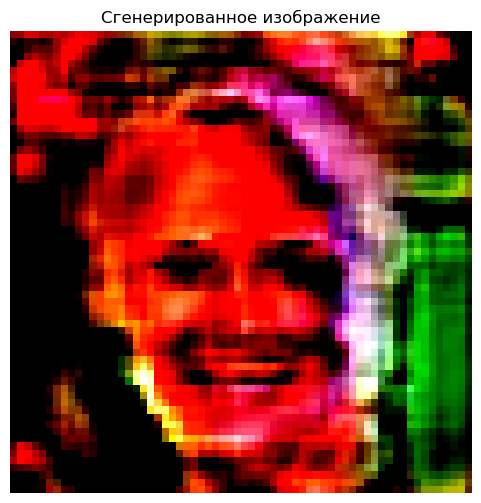

In [68]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
    # s_trg = nets.style_encoder(x_ref2, y_trg) 
    x_fake = nets.generator(x_real, s_trg)

plt.figure(figsize=(6, 6))
plt.imshow(x_fake[1].permute(1, 2, 0).detach().cpu().numpy())
# plt.imshow(x_real[1].permute(1, 2, 0).detach().cpu().numpy())
plt.title("Сгенерированное изображение")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


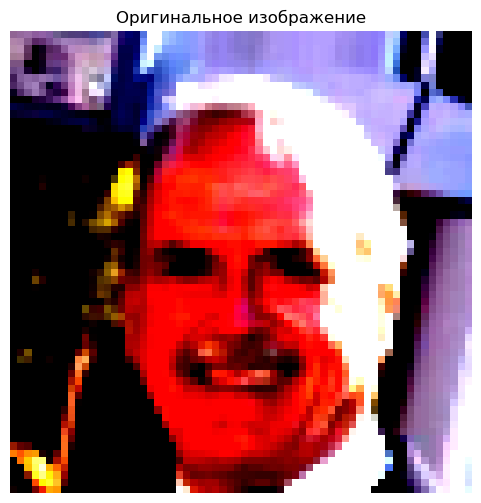

In [70]:
plt.figure(figsize=(6, 6))
plt.imshow(x_real[1].permute(1, 2, 0).detach().cpu().numpy())
plt.title("Оригинальное изображение")
plt.axis('off')
plt.show()

## Этап 3. Дополнительный анализ

В данном разделе рекомендуется провести дополнительные эксперименты и анализ:
- **Анализ латентного пространства**. *(2 балла)*
- **Текстовое ревью решения**: опишите, какие изменения можно внести для улучшения модели, и обоснуйте их. *(1 балл)*

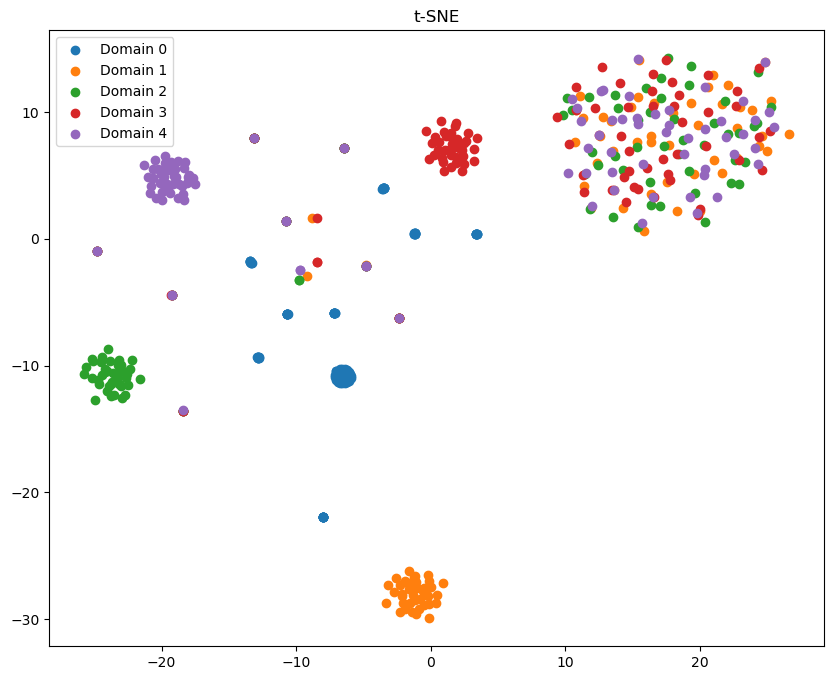

In [143]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

z = torch.randn(100, args.latent_dim).to(device)

styles = []
labels = []
for domain in range(5):
    s = nets.mapping_network(z[domain*20:(domain+1)*20], torch.full((100,), domain).to(device))
    styles.append(s.cpu().detach().numpy())
    labels.extend([domain]*100)

tsne = TSNE(n_components=2)
projections = tsne.fit_transform(np.concatenate(styles))

plt.figure(figsize=(10,8))
for domain in range(5):
    idx = np.array(labels) == domain
    plt.scatter(projections[idx,0], projections[idx,1], label=f'Domain {domain}')
plt.legend()
plt.title('t-SNE')
plt.show()

1. Генератор может терять детали в крупных объектах, поэтому стоит ввести self-attention слои в середину генератора. Attention улучшает моделирование глобальных зависимостей, что критично для согласованной генерации сложных сцен.

2. AdaIN не учитывает пространственную информацию при применении стиля. Поэтому можно использовать SPADE (Spatially-Adaptive Normalization). SPADE позволяет адаптивно применять стиль к разным регионам изображения, сохраняя локальные детали.

3. Cycle consistency loss (L1) не учитывает семантическую согласованность, поэтому можно добавить VGG-based perceptual loss. Перцептуальные потери лучше сохраняют высокоуровневые особенности изображения.

4. Фиксированные маски ограничивают гибкость. Можно использовать предобученную модель сегментации (например, U-Net) для динамической генерации масок. Это позволит точнее выделять редактируемые регионы для разных доменов.